# Homework 1

In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 180 (delta 78), reused 133 (delta 49), pack-reused 0
Receiving objects: 100% (180/180), 28.64 MiB | 31.57 MiB/s, done.
Resolving deltas: 100% (78/78), done.
renamed 'dul_2021/Homework/hw1/data/hw1_data/geoffrey-hinton.jpg' -> 'dul_2021/Homework/hw1/data/geoffrey-hinton.jpg'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist_colored.pkl' -> 'dul_2021/Homework/hw1/data/mnist_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist.pkl' -> 'dul_2021/Homework/hw1/data/mnist.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes_colored.pkl' -> 'dul_2021/Homework/hw1/data/shapes_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes.pkl' -> 'dul_2021/Homework/hw1/data/shapes.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/smiley.jpg' -> 'dul_2021/Homework/hw1/data/smiley.jpg'
Processing ./dul_

In [ ]:
from dul_2021.utils.hw1_utils import *

In [ ]:
import torch
import torch.nn as nn
import torch.optim as opt
import torch.utils.data
import torch.nn.functional as F

from PIL import Image
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
plt.rcParams["axes.labelsize"] = 25.
plt.rcParams["xtick.labelsize"] = 20.
plt.rcParams["ytick.labelsize"] = 20.
plt.rcParams["legend.fontsize"] = 18.

plt.rcParams["figure.figsize"] = [8., 6.]

In [ ]:
class Histogram(nn.Module):
    def __init__(self,):
        super().__init__()
    
    def nll(self, batch):
        raise NotImplementedError()
    
    def probs(self):
        raise NotImplementedError()

    def test(self, data_loader):
        loss = 0
        den = 0
        for batch in data_loader:
            batch_loss = self.nll(batch.to(device)) * batch.shape[0]
            loss += batch_loss.cpu().detach().item()
            den += batch.shape[0]

        return loss / den

    def fit(self,
            train_data,
            test_data,
            num_epochs=10,
            batch_size=32,
            lr=1e-3,
            collator=None):
        

        train_loader = torch.utils.data.DataLoader(train_data, 
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   collate_fn=collator)
        
        test_loader = torch.utils.data.DataLoader(train_data, 
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  collate_fn=collator)
        
        optim = opt.Adam(self.parameters(), lr)
        train_nll = []
        test_nll = []


        self.to(device)
        for epoch in range(num_epochs):
            tr_losses = []
            for batch in train_loader:
                batch = batch.to(device)

                loss = self.nll(batch)

                optim.zero_grad()
                loss.backward()
                optim.step()

                tr_loss = loss.detach().cpu().item()
                train_nll.append(tr_loss) # 
                tr_losses.append(tr_loss)
            # train_nll.append(np.mean(tr_losses)) # 
            print(f'Epoch {epoch}: {np.mean(tr_losses)}')
            
            test_loss = self.test(test_loader)
            test_nll.append(test_loss)

        return train_nll, test_nll

class MaskedLinear(nn.Linear):    
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)        
        self.register_buffer('mask', torch.ones(out_features, in_features))
        
    def set_mask(self, mask):
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.uint8).T))
        
    def forward(self, input):
        return F.linear(input, self.mask * self.weight, self.bias)


# MADE

In this question, you will implement [MADE](https://arxiv.org/abs/1502.03509). In the first part, you will use MADE to model a simple 2D joint distribution, and in the second half, you will train MADE on image datasets.

## Part (a) Fitting 2D Data

First, you will work with bivariate data of the form $x = (x_0,x_1)$, where $x_0, x_1 \in \{0, \dots, d\}$. We can easily visualize a 2D dataset by plotting a 2D histogram. Run the cell below to visualize our datasets.

Dataset 1


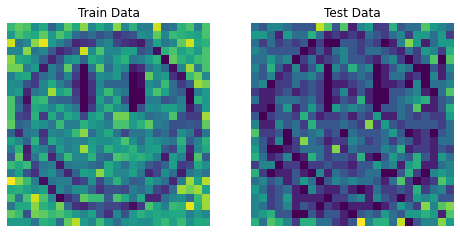

Dataset 2


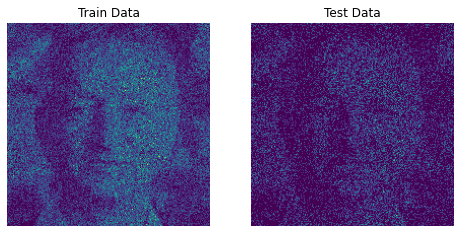

In [ ]:
visualize_q1a_data(dset_type=1)
visualize_q1a_data(dset_type=2)
# you can access data with get_data_q1_a(dset_type=1)

Implement and train a MADE model through maximum likelihood to represent $p(x_0, x_1)$ on the given datasets, with any autoregressive ordering of your choosing. 

A few notes:
* You do not need to do training with multiple masks
* You made find it useful to one-hot encode your inputs. 

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Visualize the learned 2D distribution by plotting a 2D heatmap


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
class MADE_1(Histogram):
    def __init__(self, in_dim=2, val_num=25, hidden_dim=150, hidden_layers_num=1):
        super().__init__()

        self.m = {}

        # some init
        self.in_dim = in_dim
        self.val_num = val_num
        self.model = self.model_init(in_dim, val_num, hidden_dim, hidden_layers_num)

    def model_init(self, in_dim, val_num, hidden_dim, hidden_layers_num, ordering=None):
        if ordering is None:
            self.m[-1] = np.arange(in_dim)
        else:
            self.m[-1] = ordering

        # стакаем слои
        layers = []
        layer_0 = MaskedLinear(in_dim * val_num, hidden_dim)
        act_0 = nn.ReLU()
        layers.extend([layer_0, act_0])
        for i in range(hidden_layers_num - 1):
            self.m[i] = np.random.randint(self.m[i - 1].min(), self.in_dim - 1, size=hidden_dim)
            layer_i = MaskedLinear(hidden_dim, hidden_dim)
            act_i = nn.ReLU()
            layers.extend([layer_i, act_i])
        
        layer_n = MaskedLinear(hidden_dim, in_dim * val_num)
        layers.append(layer_n)
        i = hidden_layers_num - 1
        self.m[i] = np.random.randint(self.m[i - 1].min(), self.in_dim - 1, size=hidden_dim)

        # собираем маски и добавляем нагенеренные маски в соответствующие слои
        masks = [self.m[i-1][:, None] <= self.m[i][None, :] for i in range(hidden_layers_num)]
        masks.append(self.m[hidden_layers_num - 1][:, None] < self.m[-1][None, :])
        masks[-1] = np.repeat(masks[-1], val_num, axis=1)
        masks[0] = np.repeat(masks[0], val_num, axis=0)
 
        for i in range(len(masks)):
            layers[2 * i].set_mask(masks[i])

        model = nn.Sequential(*layers)
        return model

    def forward(self, x):
        # x [bs, in_dim]
        x = F.one_hot(x, self.val_num).float() # [bs, in_dim, val_num]
        x = x.view(-1, self.in_dim * self.val_num)
        logits = self.model(x) # [bs, in_dim * val_num]
        return logits 

    def nll(self, batch):
        # batch [bs, in_dim]
        logits = self.forward(batch) # [bs, in_dim * val_num]
        logits = logits.view(-1, self.in_dim, self.val_num) 
        logits = logits.permute(0, 2, 1).contiguous().view(-1, self.val_num, self.in_dim)
        return F.cross_entropy(logits, batch)


    def distribution(self):
        with torch.no_grad():
            res = torch.zeros((self.val_num, self.val_num))

            for i in range(self.val_num):
                for j in range(self.val_num):
                    input_ij = torch.LongTensor([i, j]).reshape(1, -1).to(device)
                    out = self(input_ij)[0]
                    out = out.reshape(2, -1)
                    out = out.softmax(1)
                    res[i, j] = out[0][i] * out[1][j]

            res = res.detach().cpu().numpy()
            return res

In [ ]:
def q1_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train, 2) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test, 2) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for each random variable x1 and x2
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d, d) of probabilities (the learned joint distribution)
    """
          
    model = MADE_1(2, d, 1024, 3)
    train_loss, test_loss = model.fit(train_data, test_data, num_epochs=20, lr=1e-3, batch_size=1024)
    probs = model.distribution()
    return train_loss, test_loss, probs

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



Epoch 0: 3.214156359434128
Epoch 1: 3.2040256559848785
Epoch 2: 3.1904189586639404
Epoch 3: 3.1795058250427246
Epoch 4: 3.1738246083259583
Epoch 5: 3.1687821745872498
Epoch 6: 3.1648125052452087
Epoch 7: 3.162382811307907
Epoch 8: 3.1609909534454346
Epoch 9: 3.160840332508087
Epoch 10: 3.160359799861908
Epoch 11: 3.1591686010360718
Epoch 12: 3.1588921546936035
Epoch 13: 3.1580252051353455
Epoch 14: 3.1575646698474884
Epoch 15: 3.157425820827484
Epoch 16: 3.1568260490894318
Epoch 17: 3.1559593975543976
Epoch 18: 3.155948042869568
Epoch 19: 3.15590837597847
Final Test Loss: 3.1523


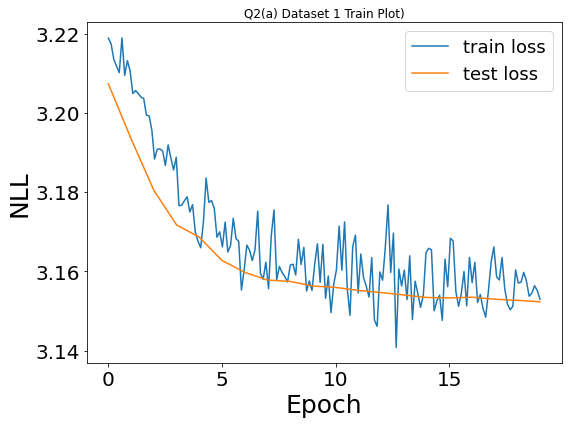

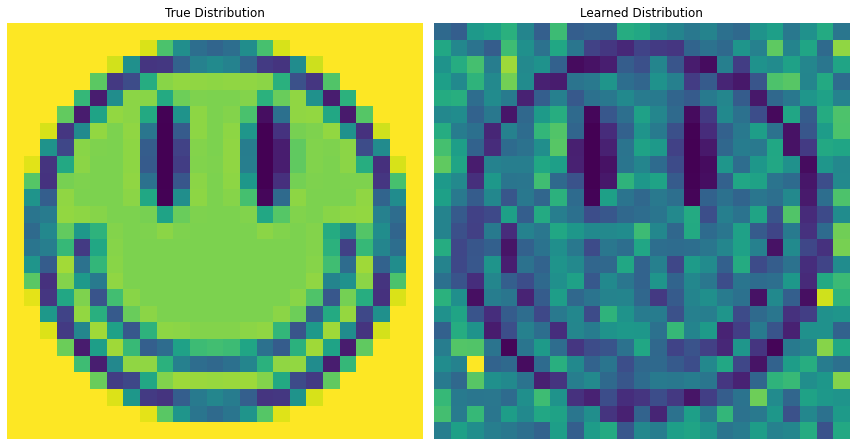

In [ ]:
q1_save_results(1, 'a', q1_a)

Epoch 0: 5.281415589248078
Epoch 1: 5.276160421250742
Epoch 2: 5.2727864060220835
Epoch 3: 5.268893585929388
Epoch 4: 5.263962612876409
Epoch 5: 5.259322329412533
Epoch 6: 5.254959052122092
Epoch 7: 5.250100908400137
Epoch 8: 5.244776146321357
Epoch 9: 5.238203658333307
Epoch 10: 5.231221060209636
Epoch 11: 5.22419423694852
Epoch 12: 5.216795402237132
Epoch 13: 5.210282621504385
Epoch 14: 5.203537210633483
Epoch 15: 5.197300059885919
Epoch 16: 5.191845688638808
Epoch 17: 5.187135980099062
Epoch 18: 5.183614670475827
Epoch 19: 5.179633774334872
Final Test Loss: 5.1588


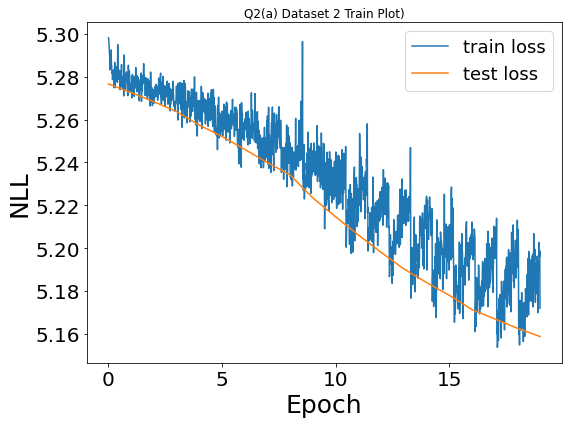

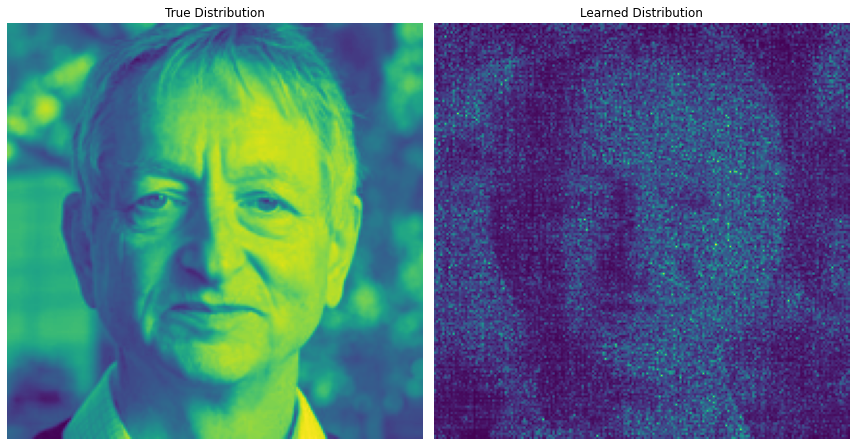

In [ ]:
q1_save_results(2, 'a', q1_a)

## Part (b) Shapes and MNIST
Now, we will work with a higher dimensional datasets, namely a shape dataset and MNIST. Run the cell below to visualize the two datasets

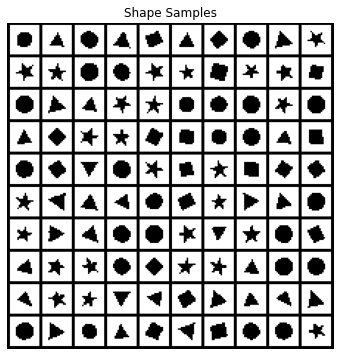

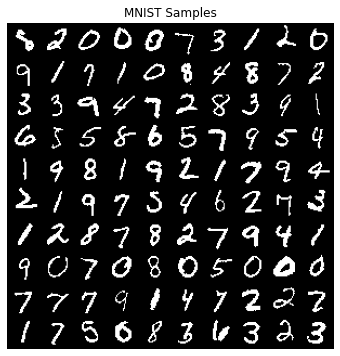

In [ ]:
visualize_q1b_data(1)
visualize_q1b_data(2)
# you can access data with get_data_q1_b(dset_type=1)

Implement and train a MADE model on the given binary image datasets. Given some binary image of height $H$ and width $W$, we can represent image $x\in \{0, 1\}^{H\times W}$ as a flattened binary vector $x\in \{0, 1\}^{HW}$ to input into MADE to model $p_\theta(x) = \prod_{i=1}^{HW} p_\theta(x_i|x_{<i})$. Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine).

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model

In [ ]:
data = get_data_q1_b(dset_type=1)
len(data), data[0].shape

(10479, (20, 20, 1))

In [ ]:
data = get_data_q1_b(dset_type=2)
len(data), data[0].shape

(60000, (28, 28, 1))

In [ ]:
class MADE_2(MADE_1):
    def distribution(self):
        return None

    def sample(self):
        with torch.no_grad():
            res = torch.zeros((1, self.in_dim)).long().to(device)
            for j in range(self.in_dim):
                out = self(res)
                out = out.view(1, self.in_dim, self.val_num) 
                out = out.permute(0, 2, 1).contiguous().view(-1, self.val_num, self.in_dim)

                out = out.view(1, self.val_num, self.in_dim)
                out = out.softmax(1).squeeze(0)
                probs = out[:, j].cpu().numpy()
                idx = np.random.choice(2, p=probs)
                res[:, j] = idx
        return res


### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [ ]:
def collator(x):
    bs = len(x)
    x = torch.LongTensor(np.array(x))
    x = x.reshape(bs, -1)
    return x

In [ ]:
def q1_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: An (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """

    in_dim = np.prod(image_shape)
    model = MADE_2(in_dim, 2, 512, 2)
    train_loss, test_loss = model.fit(train_data, test_data, num_epochs=30, lr=1e-3, batch_size=128, collator=collator)


    n_samples = 100
    h, w = image_shape
    samples = []
    for _ in range(100):
        s = model.sample().cpu().numpy()[0].reshape(h, w)
        samples.append(s)
    samples = np.array(samples).reshape(n_samples, h, w, 1)
    return train_loss, test_loss, samples

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



Epoch 0: 0.2746492130000417
Epoch 1: 0.15170880334406364
Epoch 2: 0.12596529522320118
Epoch 3: 0.11116734283362947
Epoch 4: 0.10218384016941233
Epoch 5: 0.09519031353113128
Epoch 6: 0.08813763091840394
Epoch 7: 0.08205585944943311
Epoch 8: 0.07774757348546167
Epoch 9: 0.07418679336949092
Epoch 10: 0.07124916136991687
Epoch 11: 0.06870418305440647
Epoch 12: 0.06642080021158951
Epoch 13: 0.064431535170936
Epoch 14: 0.06275561133899339
Epoch 15: 0.06118033976271385
Epoch 16: 0.059825555307836065
Epoch 17: 0.05861403902129429
Epoch 18: 0.05763594320089352
Epoch 19: 0.056547398020218055
Epoch 20: 0.05551099822652049
Epoch 21: 0.054732038298758064
Epoch 22: 0.0539466251233002
Epoch 23: 0.053251746360485144
Epoch 24: 0.052594283686541926
Epoch 25: 0.051890399397873294
Epoch 26: 0.051451727111892005
Epoch 27: 0.0507692607437692
Epoch 28: 0.05020661365876838
Epoch 29: 0.04986262971126452
Final Test Loss: 0.0495


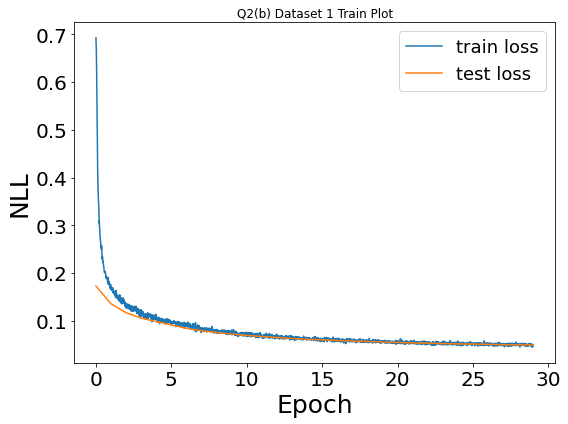

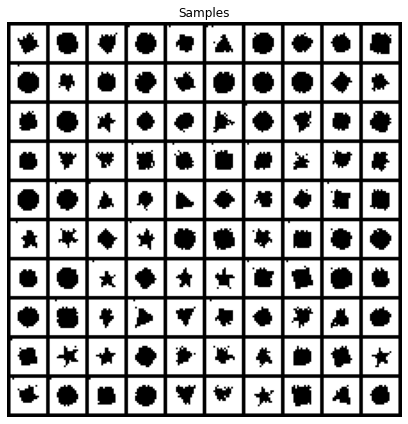

In [ ]:
q1_save_results(1, 'b', q1_b)

Epoch 0: 0.25780789633549606
Epoch 1: 0.18463358130536353
Epoch 2: 0.15899097677995402
Epoch 3: 0.1472887197283031
Epoch 4: 0.1404933840163481
Epoch 5: 0.13606716335010427
Epoch 6: 0.13289359427972644
Epoch 7: 0.13048049481883486
Epoch 8: 0.12869190585130313
Epoch 9: 0.12714914337340702
Epoch 10: 0.12593964439655927
Epoch 11: 0.12489053757904943
Epoch 12: 0.12400914166273592
Epoch 13: 0.12335180788279088
Epoch 14: 0.12257117434923075
Epoch 15: 0.12209654548592659
Epoch 16: 0.1215477648860356
Epoch 17: 0.12108044877553037
Epoch 18: 0.12081266247006113
Epoch 19: 0.12046388444552289
Epoch 20: 0.12010297090259951
Epoch 21: 0.11982610883679726
Epoch 22: 0.11957424693206735
Epoch 23: 0.11928443655149261
Epoch 24: 0.11908329265521787
Epoch 25: 0.11890031797672386
Epoch 26: 0.1186575603955336
Epoch 27: 0.11846390021825905
Epoch 28: 0.11828053113557636
Epoch 29: 0.11812956326170516
Final Test Loss: 0.1175


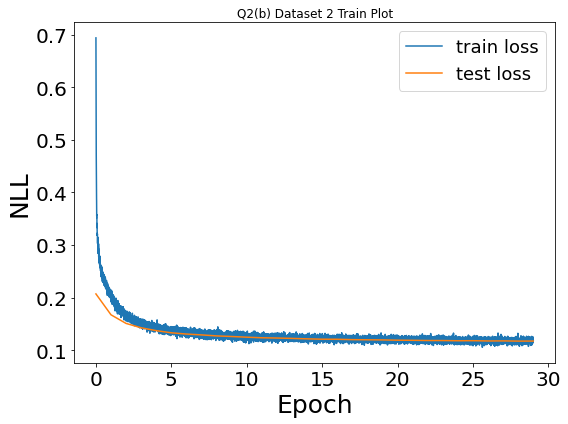

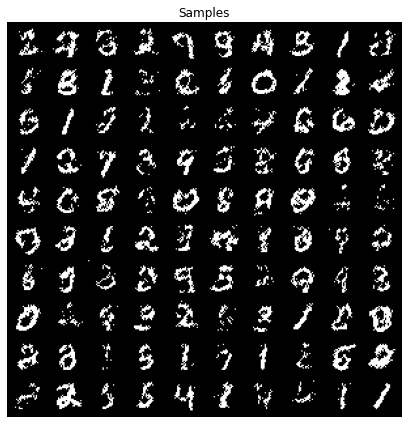

In [ ]:
q1_save_results(2, 'b', q1_b)